In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

#import math #計算combinations
import random #做隨機抽樣分布

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

from tqdm import tqdm

In [2]:
#Systemic lupus erythematosus (SLE)
raw = sc.read_h5ad("GSE174188/GSE174188_CLUES1_adjusted.h5ad")
raw

AnnData object with n_obs × n_vars = 1263676 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
SLE = raw[raw.obs.Status != "Healthy", :]

del raw
SLE

View of AnnData object with n_obs × n_vars = 777258 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# 將細胞數量過少的移除
### 總細胞數 < 0.5% remove
### 總cell type數 < 0.5% remove

In [4]:
rows_to_remove = []
sample = list(set(SLE.obs.ind_cov))
for i in sample:
    if SLE[SLE.obs.ind_cov == i,:].n_obs < SLE.n_obs*0.005:
        rows_to_remove.append(i)
        
SLE_filter = SLE[~SLE.obs.ind_cov.isin(rows_to_remove),:]    

#del SLE
SLE_filter

View of AnnData object with n_obs × n_vars = 558952 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
# 原本 162人 remove < 0.05% after filter 94人
sample_filter = list(set(SLE_filter.obs.ind_cov))
len(sample_filter)

94

# Adjust cell type name

In [6]:
# 新建欄位把cell type做我要的分類
def classify_cell_type(value):
    if value == "pDC" or value == "cDC":
        return "DC"
    elif value == "cM" or value == "ncM":
        return "Monocyte"
    elif value == "T4":
        return "CD4 T"
    elif value == "T8":
        return "CD8 T"
    else:
        return value
    
SLE_filter.obs["cell_type"] = SLE_filter.obs["cg_cov"].apply(classify_cell_type)

C:\Users\benson\AppData\Local\Temp\ipykernel_22180\1899169293.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  SLE_filter.obs["cell_type"] = SLE_filter.obs["cg_cov"].apply(classify_cell_type)


# 開始處理cell dispersion
### 我需要先把每個人的部分個別提取出來，最後再將每個人的NK提取出來做cell dispersion

In [7]:
personal = {}
for i in sample_filter:
    if i not in personal:
        personal[i] = SLE_filter[SLE_filter.obs.ind_cov == i, :]
len(personal)

94

In [8]:
# 將personal進行排序
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))
# 排序之後取得年齡
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])

age

['20.0',
 '21.0',
 '21.0',
 '21.0',
 '22.0',
 '23.0',
 '24.0',
 '25.0',
 '26.0',
 '27.0',
 '27.0',
 '27.0',
 '27.0',
 '27.0',
 '27.0',
 '28.0',
 '28.0',
 '29.0',
 '29.0',
 '29.0',
 '30.0',
 '31.0',
 '31.0',
 '31.0',
 '31.0',
 '32.0',
 '32.0',
 '33.0',
 '33.0',
 '34.0',
 '35.0',
 '35.0',
 '35.0',
 '36.0',
 '36.0',
 '37.0',
 '37.0',
 '37.0',
 '38.0',
 '38.0',
 '39.0',
 '39.0',
 '40.0',
 '40.0',
 '41.0',
 '41.0',
 '41.0',
 '42.0',
 '43.0',
 '43.0',
 '45.0',
 '45.0',
 '45.0',
 '46.0',
 '46.0',
 '48.0',
 '48.0',
 '49.0',
 '49.0',
 '50.0',
 '51.0',
 '51.0',
 '51.0',
 '52.0',
 '53.0',
 '54.0',
 '55.0',
 '55.0',
 '55.0',
 '55.0',
 '56.0',
 '56.0',
 '57.0',
 '57.0',
 '58.0',
 '58.0',
 '58.0',
 '58.0',
 '59.0',
 '59.0',
 '60.0',
 '61.0',
 '64.0',
 '64.0',
 '64.0',
 '65.0',
 '66.0',
 '66.0',
 '66.0',
 '68.0',
 '70.0',
 '71.0',
 '71.0',
 '83.0']

# remove 1811_1811 因為B, plasma blast都是0

In [9]:
del personal['1811_1811'],sorted_personal['1811_1811']
sample_filter.remove("1811_1811")

In [10]:
SLE_filter = SLE_filter[SLE_filter.obs.ind_cov != '1811_1811']
SLE_filter

View of AnnData object with n_obs × n_vars = 553271 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'cell_type'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
cell_type = list(set(SLE_filter.obs.cell_type))
cell_type

['B', 'Progen', 'PB', 'Monocyte', 'Prolif', 'NK', 'DC', 'CD8 T', 'CD4 T']

In [12]:
personal = {}
total_cells = []
for i in sample:
    if i not in personal:
        personal[i] = SLE[SLE.obs.ind_cov == i, :]
        total_cells.append(SLE[SLE.obs.ind_cov == i, :].n_obs/SLE.n_obs)

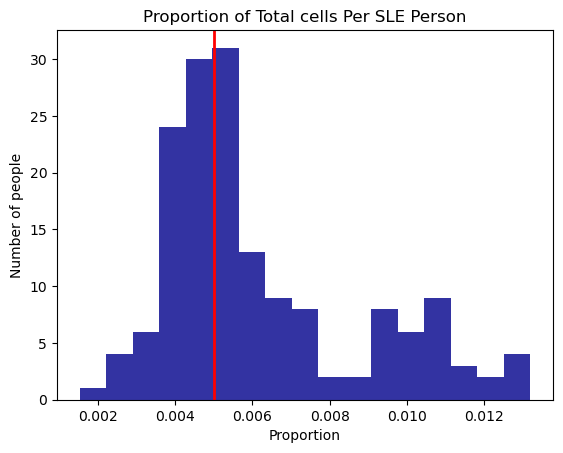

In [13]:
# 建立分布圖
plt.hist(total_cells, bins=17,alpha = 0.8, color='darkblue')

# 畫一條紅線在0.005的位置
plt.axvline(x=0.005, color='red', linewidth=2)
# 設定圖表標題和軸標籤
plt.title('Proportion of Total cells Per SLE Person')
plt.xlabel('Proportion')
plt.ylabel('Number of people')
# 將圖形保存為PNG文件
plt.savefig('Result_picture/GSE174188/Proportion of Total cells Per SLE Person.png')
# 顯示圖表
plt.show()

Text(0, 0.5, 'Count')

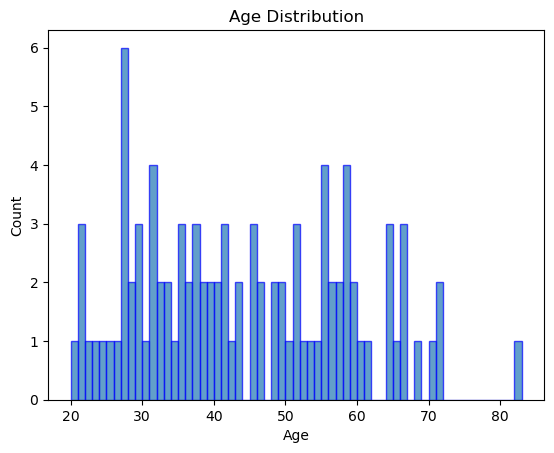

In [14]:
ages = list(map(int, map(float, age)))
plt.hist(ages, bins=range(min(ages), max(ages) + 1), alpha=0.7, edgecolor='blue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# Proportion

## total(人)/total(all)

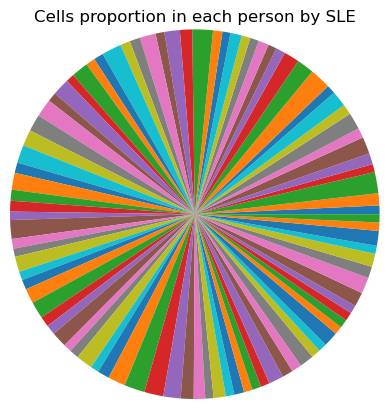

In [15]:
total_cell = 0
person_proportion = []
ID = []
total_cell = SLE_filter.n_obs

for i in sorted_personal:
    total_person_cell = sorted_personal[i].n_obs / total_cell
    ID.append(i)
    person_proportion.append(round(total_person_cell*100,2))
    #print(f"Total(人):{sorted_personal[i].n_obs}\t person Proportion:{round(total_person_cell*100,2)}%")
    
plt.pie(person_proportion, radius = 1.25)
# displaying the title
plt.title("Cells proportion in each person by SLE")

# 將圖形保存為PNG文件
plt.savefig('Result_picture/GSE174188/Cells proportion in each person_SLE.png', dpi=900)


## cell type(人)/total(人)

個人所有的細胞 分之 各種cell type

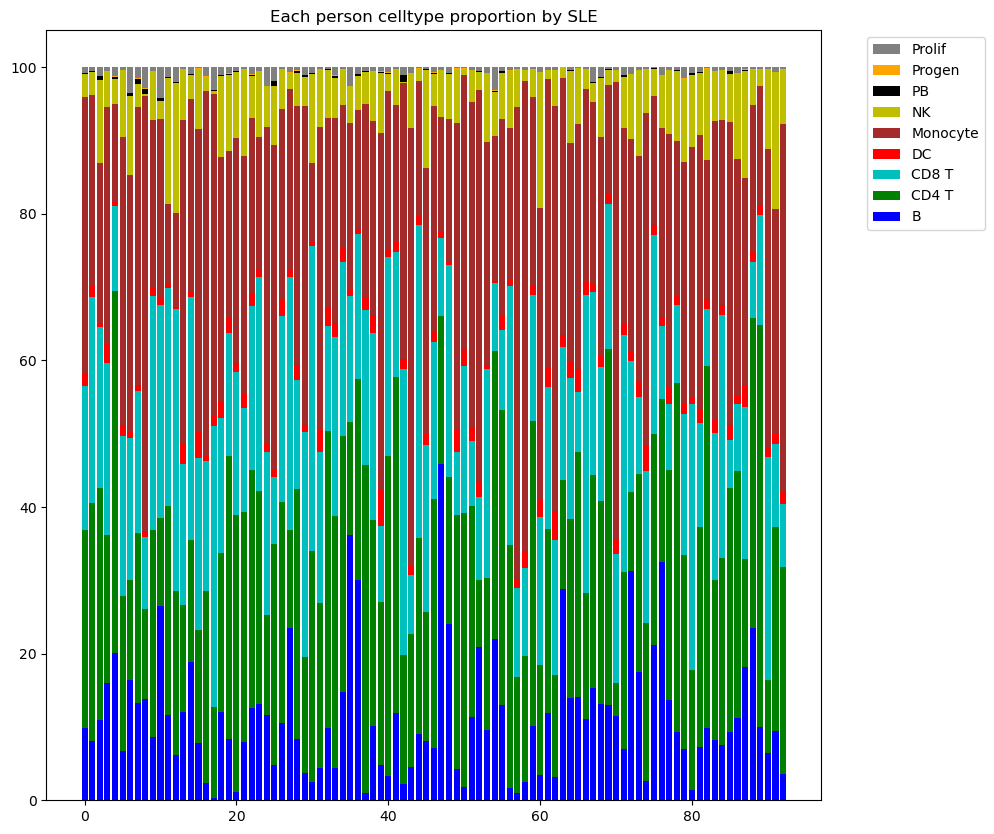

In [17]:
total_personal = []
for i in sorted_personal: # 99人
    person = []
    for j in sorted(cell_type): # 11種
        a = sorted_personal[i][sorted_personal[i].obs.cell_type == j,:].n_obs / sorted_personal[i].n_obs
        person.append(round(a*100, 2))
        #print(f"{i}的{j}佔個人cell type : {round(a*100,2)}%")
    total_personal.append(person)
    
# 創建一個新的圖形
plt.subplots(figsize=(10, 10))

total_array = np.array(total_personal)

# random select 11 types of color
colors = 'b', 'g', 'c', 'r', 'brown', 'y', 'k', '#FFA500', '#808080'


# 創建一個Patch對象的列表，並將其傳遞給legend函數
legend_elements = [Patch(facecolor=colors[i], label=sorted(cell_type)[i]) for i in range(len(cell_type))]

# 反轉圖例的順序
legend_elements.reverse()
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 1)

bottom = np.zeros(len(total_array))  # 99 bar
for i in range(len(total_array.T)):  # 11 cell types
    # total_array.T之後每一列同一種cell type中不同的99個人
    plt.bar(range(len(total_array)), total_array.T[i], bottom = bottom, color = colors[i])
    bottom += total_array.T[i]
    
plt.title("Each person celltype proportion by SLE")
# 將圖形保存為PNG文件
plt.savefig('Result_picture/GSE174188/Each person celltype proportion by SLE.png', dpi=900, bbox_inches='tight')
# 顯示圖形
plt.show()

## cell type(人)/cell type(total)

In [ ]:
pie_celltype = {}
celltype_stackbar = []
count = 0

for i in cell_type:
    # cell type total，所有人的這種cell type細胞總數
    a = SLE_filter[SLE_filter.obs.cell_type == i, :]
    pie_celltype[i] = []
    celltype_stackbar.append([])
    # cell type 
    for j in sorted_personal:
        # cell type by personal，單個人的這種cell type細胞總數
        b = sorted_personal[j][sorted_personal[j].obs.cell_type == i, :]
        # calculate proportion 
        c = b.n_obs / a.n_obs        
        # 放入這個cell type不同人的比例
        pie_celltype[i].append(round(c*100, 4))        
        #print(f"{j} 的 {i} 佔所有 {i} : {round(c*100, 2)}%")
        celltype_stackbar[count].append(round(c*100, 4))
    count += 1 

In [ ]:
celltype_stackbar_array = np.array(celltype_stackbar)
len(celltype_stackbar_array.T)

## cell type(人)/cell type(total)

In [19]:
pie_celltype = {}
celltype_stackbar = []
count = 0

for i in cell_type:
    # cell type total，所有人的這種cell type細胞總數
    a = SLE_filter[SLE_filter.obs.cell_type == i, :]
    pie_celltype[i] = []
    celltype_stackbar.append([])
    # cell type 
    for j in sorted_personal:
        # cell type by personal，單個人的這種cell type細胞總數
        b = sorted_personal[j][sorted_personal[j].obs.cell_type == i, :]
        # calculate proportion 
        c = b.n_obs / a.n_obs        
        # 放入這個cell type不同人的比例
        pie_celltype[i].append(round(c*100, 4))        
        #print(f"{j} 的 {i} 佔所有 {i} : {round(c*100, 2)}%")
        celltype_stackbar[count].append(round(c*100, 4))
    count += 1 

In [20]:
celltype_stackbar_array = np.array(celltype_stackbar)
len(celltype_stackbar_array.T)

93

In [21]:
# 每個人各自的cell type proportion

cell_type_proportion = []
for i in cell_type:
    cell_type_proportion.append(f"Proportion_{i}")
proportion_person = pd.DataFrame(total_array, columns=cell_type_proportion)


# 將DataFrame寫到CSV中
proportion_person.to_csv('Proportion_by_SLE_20240308.csv', index=True)

## cell type(人)/cell type(total)

In [24]:
pie_celltype = {}
celltype_stackbar = []
count = 0

for i in sorted(cell_type):
    # cell type total，所有人的這種cell type細胞總數
    a = SLE_filter[SLE_filter.obs.cell_type == i, :]
    pie_celltype[i] = []
    celltype_stackbar.append([])
    # cell type 
    for j in sorted_personal:
        # cell type by personal，單個人的這種cell type細胞總數
        b = sorted_personal[j][sorted_personal[j].obs.cell_type == i, :]
        # calculate proportion 
        c = b.n_obs / a.n_obs        
        # 放入這個cell type不同人的比例
        pie_celltype[i].append(round(c*100, 4))        
        #print(f"{j} 的 {i} 佔所有 {i} : {round(c*100, 2)}%")
        celltype_stackbar[count].append(round(c*100, 4))
    count += 1 

In [25]:
celltype_stackbar_array = np.array(celltype_stackbar)
len(celltype_stackbar_array.T)

93

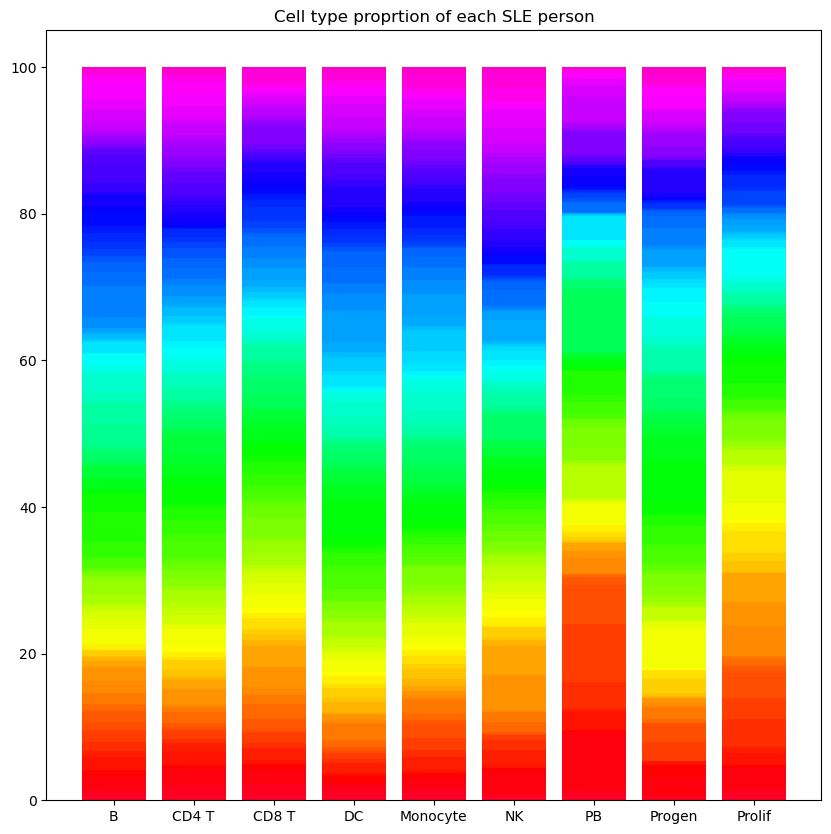

In [26]:
# 創建一個新的圖形
plt.subplots(figsize=(10, 10))
# 獲取colormap
cm = plt.get_cmap('gist_rainbow')


bottom = np.zeros(len(celltype_stackbar_array)) # 11 bar
# 使用bar函數繪製堆疊柱狀圖
for i in range(len(celltype_stackbar_array.T)):
    # celltype_stackbar_array是每一列同一種cell type中不同的99個人
    plt.bar(range(len(celltype_stackbar_array)), celltype_stackbar_array.T[i], bottom = bottom, color = cm(1.*i/len(celltype_stackbar_array.T)))
    bottom += celltype_stackbar_array.T[i]

    
plt.xticks(range(len(cell_type)), sorted(cell_type))
plt.title("Cell type proprtion of each SLE person")
# 將圖形保存為PNG文件
plt.savefig('Result_picture/GSE174188/Cell type proprtion of each SLE person.png')
# 顯示圖形
plt.show()

In [ ]:
from collections import defaultdict

for i in cell_type:
    cell_type_cell_count = defaultdict(list)
    for j in sorted_personal:
        age_each = int(float(sorted_personal[j].obs['Age'][0]))
        cell_count = sorted_personal[j][sorted_personal[j].obs.cell_type == i, :].n_obs
        cell_type_cell_count[age_each].append(cell_count)

    avg_cell_type_cell_count = {age_each: sum(counts)/len(counts) for age_each, counts in cell_type_cell_count.items()}
    ages = list(avg_cell_type_cell_count.keys())
    avg_counts = list(avg_cell_type_cell_count.values())

    plt.subplots(figsize=(16, 4))
    plt.plot(ages, avg_counts, color='blue', linestyle="--")
    # 計算趨勢線的參數
    z = np.polyfit(ages, avg_counts, 1)
    # 創建一個多項式函數
    p = np.poly1d(z)
    # 在圖中添加趨勢線
    plt.plot(ages, p(ages), 'r--', label='Trend Line')
    plt.title(i)
    plt.xlabel('Age', fontsize="8") # 設定 x 軸標題內容及大小
    plt.ylabel('Number of cells', fontsize="6") # 設定 x 軸標題內容及大小
    
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/GSE174188/『{i}』 Number of cells per person trend by SLE.png')

In [ ]:
print("細胞數量")
count = 0
for i in cell_type:
    # cell type total，所有人的這種cell type細胞總數
    a = SLE_filter[SLE_filter.obs.cell_type == i, :]
    print(i, a.n_obs)
    count += a.n_obs
print("Total : ", SLE_filter.n_obs)

In [ ]:
# 排序之後取得年齡
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])

In [ ]:
# 青壯年 18-44
# 中老年 45~65以上

# 創建圖例元素
legend_elements = [Patch(facecolor='blue', edgecolor='blue', label='age < 44'),
                   Patch(facecolor='red', edgecolor='red', label='age >= 44')]
# 創建一個新的圖形
plt.subplots(figsize=(10, 10))
# 獲取colormap
colors = ['blue' if float(i) < 44 else 'red' for i in age]

bottom = np.zeros(len(celltype_stackbar_array)) # 9 bar
# 兩種顏色的總%數
total_blue = np.zeros(len(celltype_stackbar_array))
total_red = np.zeros(len(celltype_stackbar_array))

for i in range(len(celltype_stackbar_array.T)):
    plt.bar(range(len(celltype_stackbar_array)), celltype_stackbar_array.T[i], bottom = bottom, color = colors[i])
    if colors[i] == 'blue':
        total_blue += celltype_stackbar_array.T[i]
    else:
        total_red += celltype_stackbar_array.T[i]
    bottom += celltype_stackbar_array.T[i]

# 在每個柱子上添加藍色和紅色的比例
for j in range(len(celltype_stackbar_array)):
    total = total_blue[j] + total_red[j]
    plt.text(j, total_blue[j]/2, f'{total_blue[j]/total*100:.1f}%', ha='center', va='center', color='white', fontweight = 'bold')
    plt.text(j, total_blue[j] + total_red[j]/2, f'{total_red[j]/total*100:.1f}%', ha='center', va='center', color='white', fontweight = 'bold')

    
plt.xticks(range(len(cell_type)), cell_type)
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 1)
plt.title("Cell type proportion in old and young by SLE")
# 將圖形保存為PNG文件
plt.savefig('Result_picture/GSE174188/Cell type proportion in old and young by SLE.png')
# 顯示圖形
plt.show()

# Pearson Correlation

In [ ]:
from scipy.stats import pearsonr

def pearson_correlation(adata, cell):
    corr = []
    pvalue = []
    # extract cell type
    cell_type = adata[adata.obs.cell_type == cell,:]
    # get age and turn into float
    age_float = [float(i) for i in cell_type.obs.Age]
    for gene in cell_type.X.T: # cell_type.X.T才會是基因
        pearson_corr, p_value = pearsonr(age_float, gene)
        corr.append(pearson_corr)
        pvalue.append(p_value)
    
    return corr, pvalue

In [ ]:
# ['NK', 'DC', 'CD8T', 'Monocyte', 'CD4T', 'B', 'PB', 'Progen', 'Prolif']
pearson = {}
for i in cell_type:
    corr, pvalue = pearson_correlation(SLE_filter, i)
    pearson[i] = {"corr" : corr, "pvalue" : pvalue}

In [ ]:
# 看pvalue有哪些是顯著的
for i in cell_type:
    count = 0
    for j in pearson[i]["pvalue"]:
        if j < 0.05:
            count += 1
    print(f"cell_type:{i}")
    print(f"count:{count}")
    print(f"total:{len(pearson['PB']['pvalue'])}\n")

# Visualize correlation

In [ ]:
def visualize_correlation(cell_type, correlation_method, title):# correlation的直方圖
    for i in cell_type:

        # 分類
        positive = [j for j in correlation_method[i]["corr"] if j > 0 ]
        negative = [j for j in correlation_method[i]["corr"] if j < 0 ]

        # 計算每組的數量
        counts = [len(positive), len(negative)]

        # 計算總數
        total_count = len(positive) + len(negative)

        # 計算每組的百分比
        positive_percentage = len(positive) / total_count * 100
        negative_percentage = len(negative) / total_count * 100

        # 繪製堆疊直方圖
        plt.bar([i], [positive_percentage], color='b')
        plt.text(i, positive_percentage/2, f'{positive_percentage:.1f}%', ha='center', va='center', color='white', fontweight='bold', fontsize = '8')
        plt.bar([i], [negative_percentage], bottom=positive_percentage, color='r')
        plt.text(i, positive_percentage + negative_percentage/2, f'{negative_percentage:.1f}%', ha='center', va='center', color='white', fontweight='bold', fontsize = '8')

    #    # 計算所有相關性值的總和
    #    total_corr = sum(pearson[i]["corr"])
    #    if total_corr > 0:
    #        print(f"{i} 的整體相關性是正相關: {total_corr}")
    #    elif total_corr < 0:
    #        print(f"{i} 的整體相關性是負相關: {total_corr}")
    #    else:
    #        print(f"{i} 的整體相關性是無相關: {total_corr}")


    # 添加標籤和標題
    plt.ylabel("Percentage (%)")
    plt.title(f"Histogram of {title} Correlations")
    plt.legend(['>0', '<0'], bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 1)
    # 將x軸的標籤旋轉45度
    plt.xticks(range(len(cell_type)), cell_type, rotation=30)
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/GSE174188/Histogram of {title} Correlations(Remove overall less than 0.5%)_SLE.png', dpi=900)
    
    plt.show()  

In [ ]:
visualize_correlation(cell_type, pearson, "Pearson")

所有的gene都放進去

In [ ]:
# For GO & KEGG 
# All genes
positive = {}
negative = {}
# each gene 
for i in cell_type:
    positive[i] = []
    negative[i] = []
    for j in range(len(pearson[i]["corr"])):
        if pearson[i]["corr"][j] > 0:
            positive[i].append(SLE_filter.var.index[j])
        elif pearson[i]["corr"][j] < 0:
            negative[i].append(SLE_filter.var.index[j])
            
# 現在裡面包的是 positive or negative的 dictionary不同cell type的 gene
# positive[cell type] = gene, correlation > 0
# negative[cell type] = gene, correlation < 0

只放前兩百個genes

In [ ]:
# For GO & KEGG 
# All genes
positive = {}
negative = {}
# each gene 
for i in cell_type:
    positive[i] = []
    negative[i] = []
    
    pair= list(zip(SLE_filter.var.index, pearson[i]["corr"]))
    # 由大到小排序
    sorted_pair = sorted(pair, key = lambda x: x[1], reverse=True)
    
    for j in range(200):
        if sorted_pair[j][1] > 0:
            positive[i].append(sorted_pair[j][0])
        if sorted_pair[-j-1][1] < 0:
            negative[i].append(sorted_pair[-j][0])
            
# 現在裡面包的是 positive or negative的 dictionary不同cell type的 gene
# positive[cell type] = gene, correlation > 0
# negative[cell type] = gene, correlation < 0

# pickle 測試用


import pickle

with open('negative_gene_list.pickle','wb') as f:

    pickle.dump(negative, f)
    
    
with open('gene_list.pickle', 'rb') as f:

    test = pickle.load(f)

In [ ]:
import pandas as pd

pd_negative = pd.DataFrame.from_dict(negative, orient='index')
pd_positive = pd.DataFrame.from_dict(positive, orient='index')
# 在Python中保存為.csv文件
pd_negative.to_csv('pearson_negative_celltype_genes_top200_remove 0.5%_SLE.csv', index=True)
pd_positive.to_csv('pearson_positive_celltype_genes_top200_remove 0.5%_SLE.csv', index=True)

# 只放前兩百個genes 取ENSG

In [ ]:
# For GO & KEGG 
# All genes
positive = {}
negative = {}
# each gene 
for i in cell_type:
    positive[i] = []
    negative[i] = []
    
    pair= list(zip(SLE_filter.var.gene_ids, pearson[i]["corr"]))
    # 由大到小排序
    sorted_pair = sorted(pair, key = lambda x: x[1], reverse=True)
    
    for j in range(200):
        if sorted_pair[j][1] > 0:
            positive[i].append(sorted_pair[j][0])
        if sorted_pair[-j-1][1] < 0:
            negative[i].append(sorted_pair[-j][0])
            
# 現在裡面包的是 positive or negative的 dictionary不同cell type的 gene
# positive[cell type] = gene, correlation > 0
# negative[cell type] = gene, correlation < 0

In [ ]:
import pandas as pd

pd_negative = pd.DataFrame.from_dict(negative, orient='index')
pd_positive = pd.DataFrame.from_dict(positive, orient='index')
# 在Python中保存為.csv文件
pd_negative.to_csv('pearson_negative_celltype_genes_top200_remove 0.5%_ENSG_SLE.csv', index=True)
pd_positive.to_csv('pearson_positive_celltype_genes_top200_remove 0.5%_ENSG_SLE.csv', index=True)